# ML-based-WAF Classifier

This notebook trains a WAF model with the [WAF-A-MoLE Dataset](https://github.com/zangobot/wafamole_dataset/), based off vladan stojnic's open source [ML-based-WAF](https://github.com/vladan-stojnic/ML-based-WAF) implementation.

Tested classifier types: 
* Non-Linear SVM classifier;
* Stochastic Gradient Descent

WARNING: Only works with conda env set to mlWaf2 (provided in /deps/conda_envs).

#### Library imports


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from ray.util.joblib import register_ray
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
data_df = pd.read_json('~/localdev/db/wafamole_dataset.json' , orient='records')
data_df

,pattern,type
0,SELECT `col2` FROM `tab` WHERE `col1` LIKE '%'...,sqli
1,"DELETE FROM `tab` WHERE `col2` < ""exec sp_addl...",sqli
2,"INSERT INTO `tab` ( `col2`, `col2` ) VALUES ( ...",sqli
3,"INSERT INTO `tab` ( `col1` ) VALUES ( '"" OR EL...",sqli
4,"INSERT INTO `tab` ( `col2` ) VALUES ( ""';\n if...",sqli
...,...,...
738823,"DELETE FROM `tab` WHERE `col1` LIKE ""%'g'%"" OR...",valid
738824,"SELECT `col3`, `col3` FROM `tab` WHERE `col3` ...",valid
738825,UPDATE `tab` SET `col3` = 2 WHERE `col1` = 334...,valid
738826,"SELECT `col2`, `col1`, `col2`, `col1` FROM `ta...",valid


sqli     393629
valid    345199
Name: type, dtype: int64


<AxesSubplot:ylabel='type'>

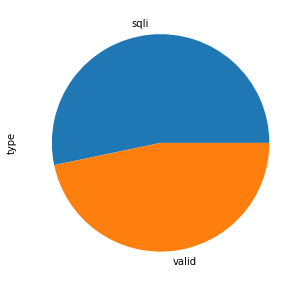

In [3]:
counts = data_df['type'].value_counts()
print(counts)
counts.plot.pie(figsize=(5, 5))

#### Split into training and testing labels


In [ ]:
X = pd.arrays.StringArray(data_df['pattern'].to_numpy()).to_numpy()
y = pd.arrays.StringArray(data_df['type'].to_numpy()).to_numpy()
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

#### Prepare for GridSearchCV classification for best params based on Classifier type
Note - Linear with ngram range [1,4] seems to peform slightly worse than rbf kernel with ngram_range [1,2].

In [6]:
# pipe = make_pipeline(
#     TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024), 
#     SVC())
# param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4)], 
#                'svc__C': [1, 10], 'svc__kernel': ['linear', 'rbf']}  
# grid = GridSearchCV(pipe, param_grid, cv = 2, verbose = 4, n_jobs=4)
# grid.fit(trainX, trainY)
# grid.best_params_

#### 1. Train model with best params and .dump export
Found by experimenting with top results from GridSearchCV run

In [9]:

pipe = make_pipeline(
    TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 2)), 
    SVC(C = 10, kernel = 'rbf', probability=True, gamma='scale'))
pipe.fit(trainX, trainY)
pipe.score(testX, testY)

joblib.dump(pipe, 'test_svc_classifier.dump')

#### 2. Train model with suggested GridSearch optimal params
**WARNING** do not run this cell if the previous cell has been executed!

Uses best result from GridSearchCV run - however the performance is slightly worse.

In [ ]:
# pipe = make_pipeline(
#     TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 4)), 
#     SVC(C = 10, kernel = 'linear', probability=True, gamma='scale'))
# pipe.fit(trainX, trainY)
# pipe.score(testX, testY)

#### Conclusion: Classification Report, Confusion Matrix
For evaluating the trained model, and generating a .dump file to be used within other apps/wafamole

In [ ]:
predY = pipe.predict(testX)
print(classification_report(testY, predY))
print(confusion_matrix(testY, predY))

#### WAF-A-MoLE query testing
For testing with and without WAF queries in dataset.

In [32]:
clf = joblib.load('test_svc_classifier_extra_moled.dump')
# query = "admin'   OR   5o8x4x4o0o1=0o4o2b4b4o0b60#"
query = "aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo;"
print("Testing query {} for SQL Injection".format(query))
print("type assumed: {}".format(clf.predict([query])))
print("probability of being SQL injection is: {}".format(clf.predict_proba([query])[0,0]))

Testing query aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo; for SQL Injection
type assumed: ['sqli']
probability of being SQL injection is: 0.7964570358168855


In [12]:
clf = joblib.load('test_svc_classifier_moled.dump')
# query = "admin'   OR   5o8x4x4o0o1=0o4o2b4b4o0b60#"
query = "aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo;"
print("Testing query {} for SQL Injection".format(query))
print("type assumed: {}".format(clf.predict([query])))
print("probability of being SQL injection is: {}".format(clf.predict_proba([query])[0,0]))

Testing query aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo; for SQL Injection
type assumed: ['valid']
probability of being SQL injection is: 0.4547222533415284
